# Deep Learning Course Project - Gesture Recognition

##### Group members: Sai Charitha Gonavaram and Prajwal Brijesh Ainapur

## Problem Statement:

   Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

   - Thumbs up:  Increase the volume
   - Thumbs down: Decrease the volume
   - Left swipe: 'Jump' backwards 10 seconds
   - Right swipe: 'Jump' forward 10 seconds  
   - Stop: Pause the movie
   

### Contents

- Modules utilized
- Generator 
- Approach 1: 2D-CNN + GRU
- Approach 2: 3D CNN
- Approach 3: Transfer Learning 


    - Mobilenet + GRU
    - Mobilenet v2 + GRU 
    
    

- Conclusion





## Modules Utilized

In [1]:
#importing some basic required modules
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
# The directory for the documents have been modified based on the directory structure of Nimblebox

train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 15#experiment with the batch size


## Generator 
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

The values of y and z have been taken at 120 based on hit and trial approach 

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    x=25
    y=120
    z=120
    img_idx =[x for x in range(0,x)]  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                     
                    #The following line resizes the entire image into the pre defined shape i.e. 120*120
                    image = imresize(image,(y,z,3))
                    
                    #Normalising images. Since the intensity values for each pixel varies from 0-255; performing 
                    image0 =  image[:,:, 0]/255.0
                    image1 =  image[:,:, 1]/255.0
                    image2 =  image[:,:, 2]/255.0
                   
                    
                    batch_data[folder,idx,:,:,0] = image0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image1#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image2#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(folder_list)%batch_size != 0):
            Remaining_data=len(folder_list) - (num_batches * batch_size)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                     
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(y,z,3))
                    
                     #Normalising images 
                    image0 =  image[:,:, 0]/255.0
                    image1 =  image[:,:, 1]/255.0
                    image2 =  image[:,:, 2]/255.0


                    batch_data[folder,idx,:,:,0] = image0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image1#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image2#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Approach 1: 2D CNN + GRU

The intution behind such an architecture is that 2DCNN will be useful in generating feature maps whereas the GRU will give us temporal features. The model architecture involves a basic 2DCNN initial layers i.e. 4 hidden layers with 16, 32, 64, 128 nodes in each layer specifically, followed by a GRU with 64 cells. The model is as following.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(25, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [7]:
from keras import optimizers
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 25, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 25, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 25, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 25, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 25, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 25, 30, 30, 64)    18496     
__________

As described in the above model summary, the number of trainable parameters is just at about 1.3 Million. Upon training the model it was observed that Training accuracy was about 84% and Validation accuracy was about 75% at about 16 epochs following which, the model started over fitting a lot.

Following Iterations to the above model were made and the results are also mentioned in detail on the report:

- Adding more GRU layers/ Dense NN layers
- Adding number of cells/neurons on the given GRU/ Dense NN layer
- Modifying the CNN layers

All the above modifications did not provide the desired results i.e. Proper data fit i.e. no under fitting or over fitting as well as good accuracy

The trained model file can be found in the following link

https://drive.google.com/file/d/1zhdQdPjxvIJ9BcKgwzOs9clki33AoOaY/view?usp=sharing



## Approach 2: 3D-CNN

Multiple architectures under this approach were trained and analyzed and the same are detailed in the report. The following is the architecure from the model which had the best results among all over iterations.

In [6]:
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()

model.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 input_shape=(25, 120, 120, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32,  
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64,  
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64,  
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 25, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 120, 120, 16)  64        
_________________________________________________________________
activation_1 (Activation)    (None, 25, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 60, 60, 32)    128       
_________________________________________________________________
activation_2 (Activation)    (None, 12, 60, 60, 32)    0         
__________

The above model was optimal in terms of results and also the parameters are very less at under 2 million parameters. The accuracy was obtained at about 85% validation accuracy and 95% training accuracy, the model is slightly overfitting. Multiple iterations of the above CNN layer was attempted with varying results. They are documented in detail in the report submission.

The model can be found in the below link:

** https://drive.google.com/file/d/1mxUI4IWOdGV6L5lMsuKG84akWAVrn2Ub/view?usp=sharing **

## Approach 3: Transfer Learning

There are lots of pre trained models available on Keras as well as online. We have selected Mobilenet trained on the image net dataset since it has fairly good performance and significantly smaller than it's counterparts such as RESNET 50, VGG19, Inception v3 etc. List of all available pre trained models can be found in the below link


https://keras.io/api/applications/


For the first iteration, Mobilenet was considered and only the layers after it were trained. It was found that the model is overfitting. Thus the following iterations were performed and the results of the same have been explained in the report in detail

- Modifying the GRU and Dense NN layers
- Replacing GRU with LSTM
- Modifying dropout values

Since none of the above iterations provided useful results, it was decided to consider weights of mobilenet layers for training. The model architecture is as follows

In [10]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

#Model Architecture
model = Sequential()

model.add(TimeDistributed(mobilenet_transfer,input_shape=(25, 120, 120, 3)))

# Code block to disable training of the mobilenet layers
# for layer in model.layers:
#     layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

#Final Softmax output layer
model.add(Dense(5, activation='softmax'))

In [11]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 25, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 25, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 25, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 25, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
__________

As described in the above model summary, the number of trainable parameters is well over 3.6 Million. 


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'TL_mobileNet_GRU_Final/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0)# write the REducelronplateau code here

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

callbacks_list = [checkpoint, LR, callback]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history_CNN = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs = 25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  ./Project_data/train ; batch size = 15
 Epoch 1/25
./Project_data/val ; batch size = 15
45/45 [==============================] - 200s 4s/step - loss: 1.0298 - categorical_accuracy: 0.5793 - val_loss: 0.7359 - val_categorical_accuracy: 0.6667

Epoch 00001: saving model to TL_mobileNet_GRU_Final/model-00001-1.02983-0.57926-0.73592-0.66667.h5
Epoch 2/25
45/45 [==============================] - 75s 2s/step - loss: 0.5042 - categorical_accuracy: 0.8059 - val_loss: 0.5351 - val_categorical_accuracy: 0.7619

Epoch 00002: saving model to TL_mobileNet_GRU_Final/model-00002-0.50424-0.80593-0.53509-0.76190.h5
Epoch 3/25
45/45 [==============================] - 70s 2s/step - loss: 0.2803 - categorical_accuracy: 0.9067 - val_loss: 0.5052 - val_categorical_accuracy: 0.8190

Epoch 00003: saving model to TL_mobileNet_GRU_Final/model-00003-0.28030-0.90667-0.50517-0.81905.h5
Epoch 4/25
45/45 [==============================] - 69s 2s/step - loss: 0.1791 - categorical_accuracy

In [16]:
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

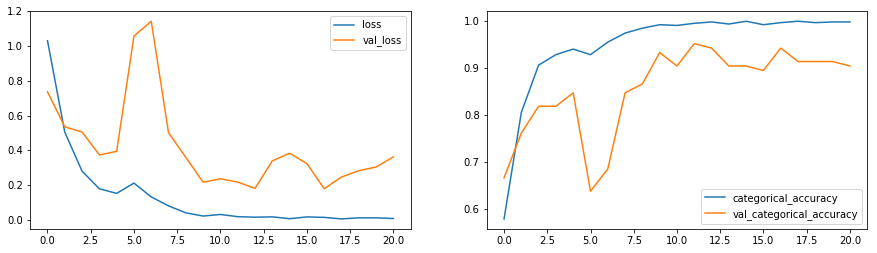

In [17]:
plot(history_CNN)

As it is evident by the above results, after certain epochs, the model slightly begins to over fit and thus early stop option stopped the training mid way. The optimal point as per the graphs is found at about 12 epoch. i.e. model checkpoint with 99% training accuracy and 95% approximately. The above model was arrived after performing multiple iterations by adjusting the number of GRU and Dense NN layers.

Another iteration of the above model was tried by replacing mobilenet with mobilenet V2 but probably due the type of feature maps that it created was very different when compared to the other version. i.e. output was of shape (30, 5060) against the current one which is (30, 1024), the results were very sub par i.e. accuracy were barely about 40-50% even over multiple epochs. Thus the preferred Transfer learning method was finalized as mobile net due to the excellent reuslts it generated for our particular use case

## Conclusion

The above model was found to be the best among all the attempted iterations and approaches. It has exceptionally well accuracy results and also the model fit is appropriate. Details of the iterations and their results is mentioned in the report